## Inicialización

In [39]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_dq import dq_report, Fix_DQ


fqd = Fix_DQ(
    quantile=0.87,
    cat_fill_value='missing',
    num_fill_value=None,
    rare_threshold=0.01,
    correlation_threshold=0.9,
)


## Cargar datos limpios

In [40]:
usage_data = pd.read_parquet('../data/clean/usage_data.parquet')

## Estudia el comportamiento de usuario

In [41]:
grouped = usage_data.groupby(['year_month', 'plan_name']).agg(
    total_payment=('total_payment', 'sum'),
    monthly_plan_fee=('monthly_plan_fee', 'sum'),
    excess_usage=('excess_usage', 'sum'),
    calls_count=('total_minutes', 'size'),
    minutes_sum=('total_minutes', 'sum'),
    sms_count=('total_sms', 'size'),
    gb_used=('total_gb', 'sum')
).reset_index()

In [42]:
print(grouped.head().to_markdown())

|    | year_month   | plan_name   |   total_payment |   monthly_plan_fee |   excess_usage |   calls_count |   minutes_sum |   sms_count |   gb_used |
|---:|:-------------|:------------|----------------:|-------------------:|---------------:|--------------:|--------------:|------------:|----------:|
|  0 | 2018-01      | surf        |          600    |                600 |           0    |            30 |           406 |          30 |        10 |
|  1 | 2018-01      | ultimate    |         1330    |               1330 |           0    |            19 |           774 |          19 |        29 |
|  2 | 2018-02      | surf        |          809.57 |                680 |         129.57 |            34 |          2673 |          34 |       110 |
|  3 | 2018-02      | ultimate    |         1190    |               1190 |           0    |            17 |          2822 |          17 |       121 |
|  4 | 2018-03      | surf        |         1496.65 |                900 |         596.65 |         

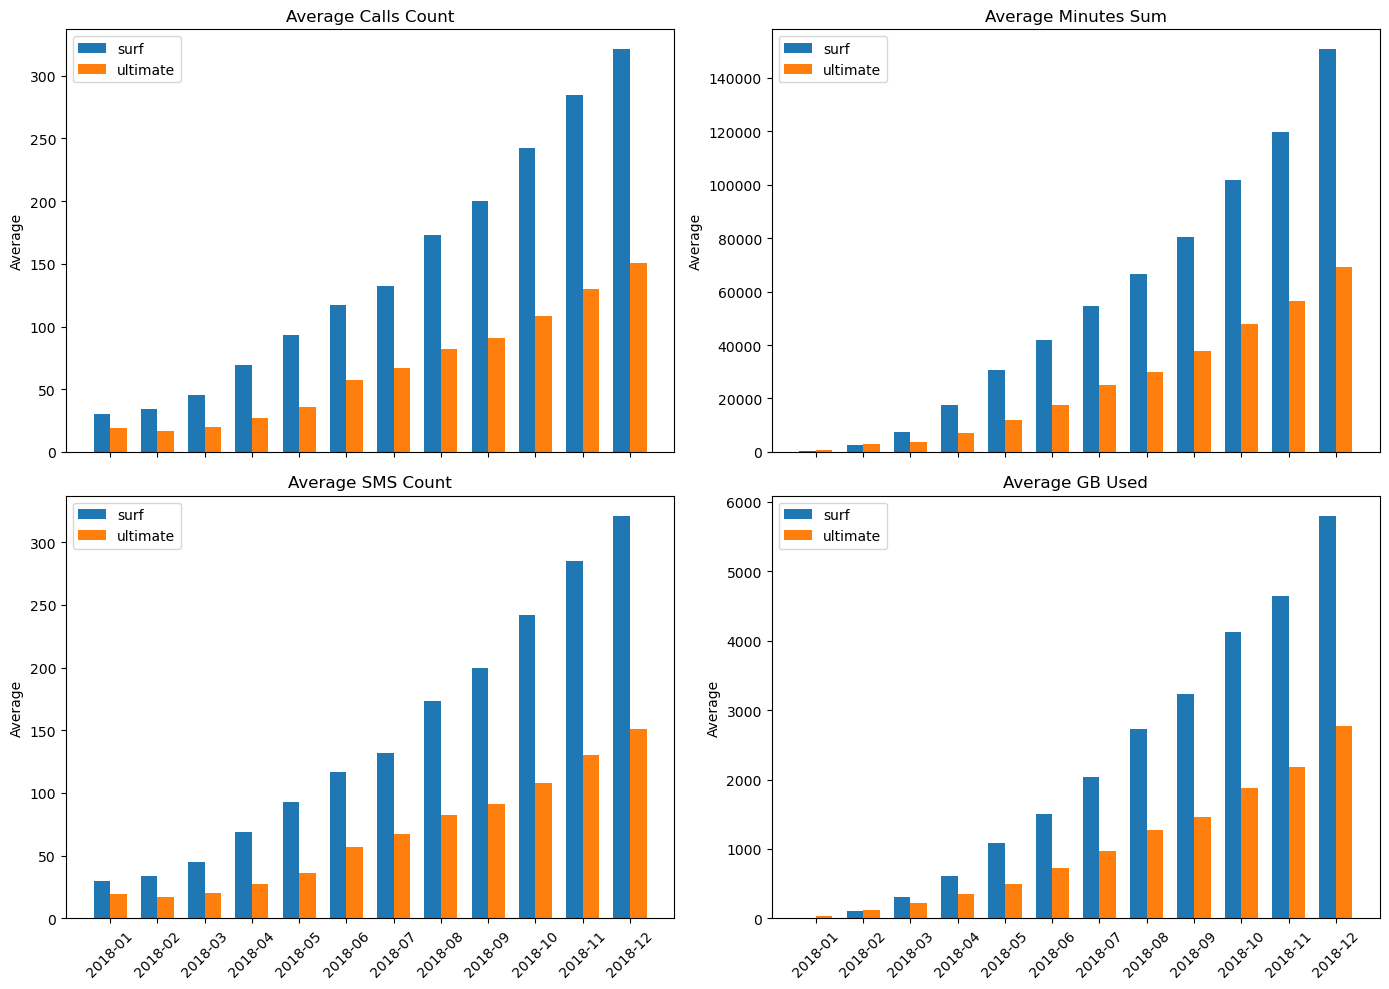

In [43]:

# Supongamos que el DataFrame `grouped` ya está definido y contiene los datos proporcionados.
# Crear el gráfico de barras
fig, ax = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

metrics = ['calls_count', 'minutes_sum', 'sms_count', 'gb_used']
titles = ['Average Calls Count', 'Average Minutes Sum', 'Average SMS Count', 'Average GB Used']

plans = grouped['plan_name'].unique()
months = grouped['year_month'].unique().astype(str)

bar_width = 0.35
index = np.arange(len(months))

for i, metric in enumerate(metrics):
    ax[i//2, i%2].set_title(titles[i])
    ax[i//2, i%2].set_ylabel('Average')
    for j, plan in enumerate(plans):
        data = grouped[grouped['plan_name'] == plan][metric]
        ax[i//2, i%2].bar(index + j * bar_width, data, bar_width, label=plan)
    
    ax[i//2, i%2].set_xticks(index + bar_width / 2)
    ax[i//2, i%2].set_xticklabels(months)
    ax[i//2, i%2].legend()
    # Apply rotation to x-tick labels for each subplot
    for tick in ax[i//2, i%2].get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()
plt.show()

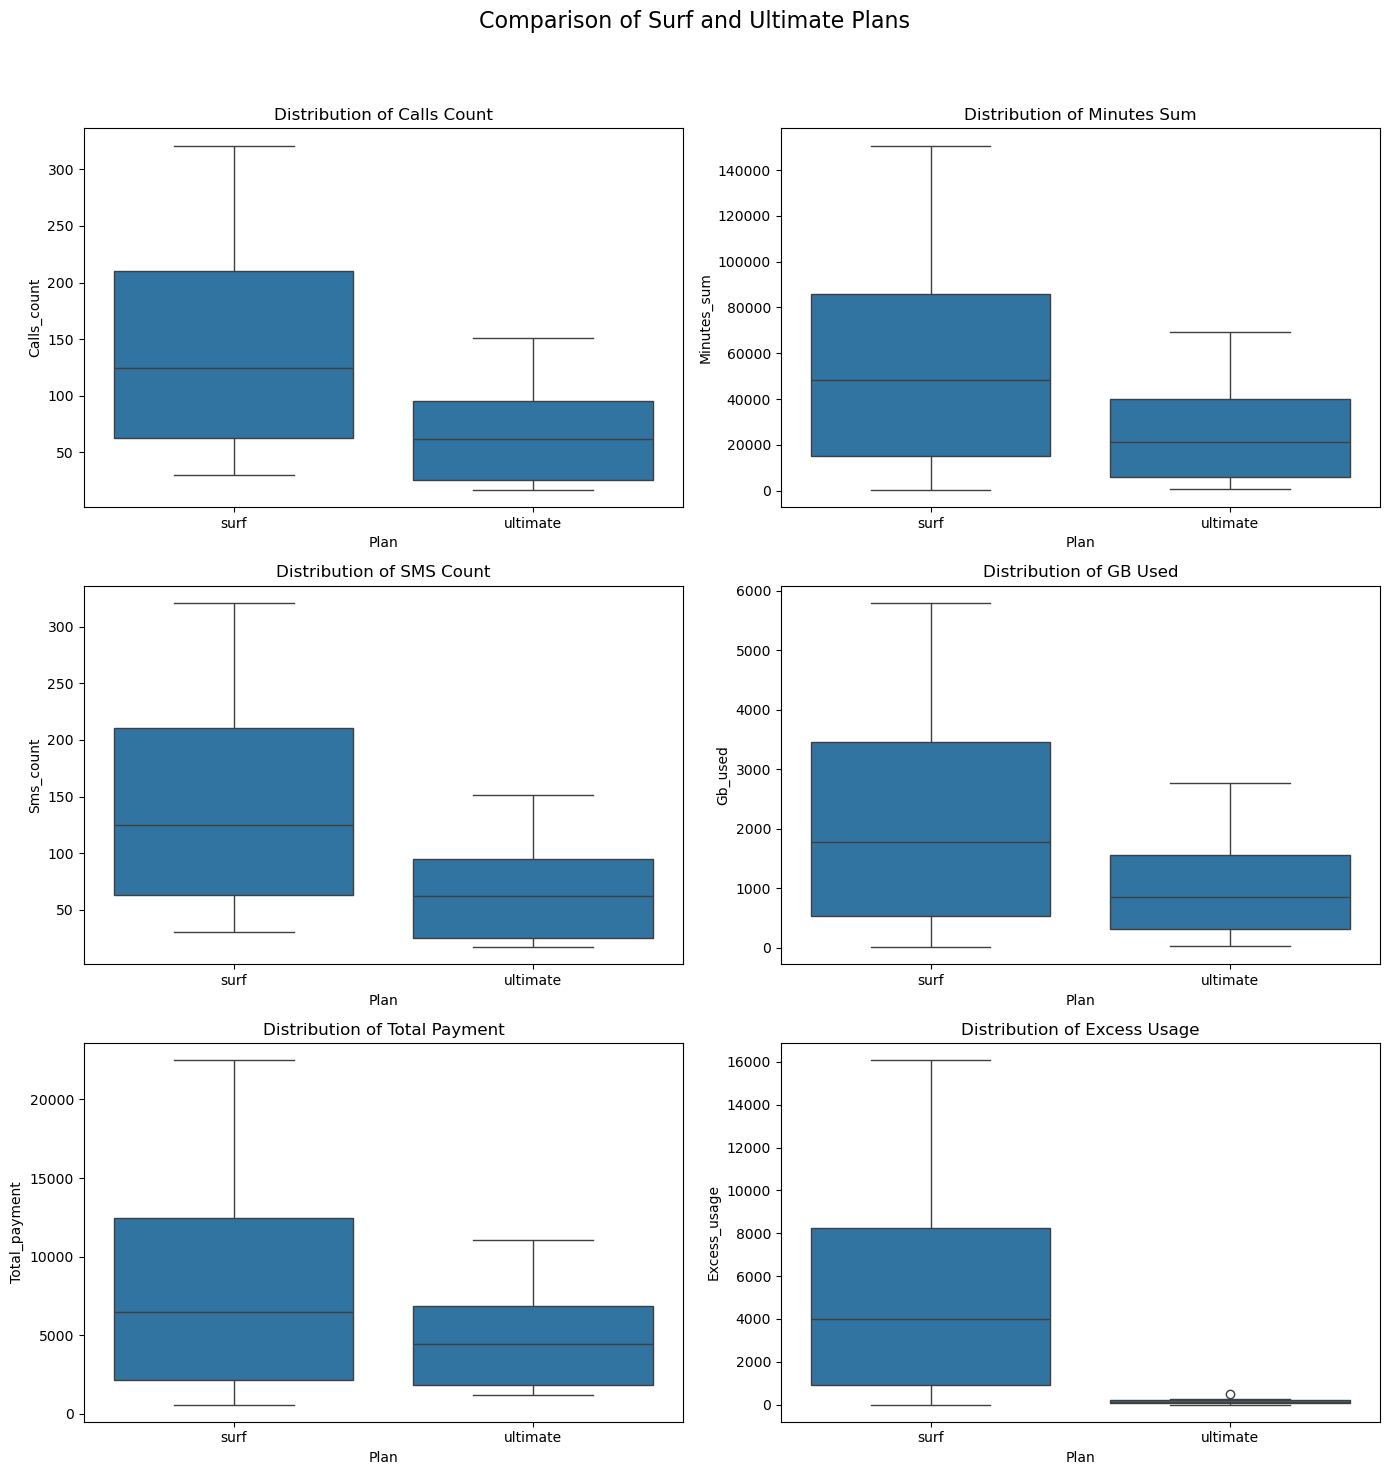

In [44]:
# Agregar columnas para diferentes categorías, incluyendo ingresos y gastos extras
categories = ['calls_count', 'minutes_sum', 'sms_count', 'gb_used', 'total_payment', 'excess_usage']
titles = ['Calls Count', 'Minutes Sum', 'SMS Count', 'GB Used', 'Total Payment', 'Excess Usage']

# Crear el gráfico de cajas y bigotes
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
fig.suptitle('Comparison of Surf and Ultimate Plans', fontsize=16)

for i, category in enumerate(categories):
    sns.boxplot(x='plan_name', y=category, data=grouped, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'Distribution of {titles[i]}')
    axes[i//2, i%2].set_ylabel(category.capitalize())
    axes[i//2, i%2].set_xlabel('Plan')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Prueba las hipótesis estadísticas

Para comparar los ingresos de los usuarios en los diferentes planes, podemos usar una prueba estadística adecuada para comparar las medias de dos grupos. En este caso, podemos utilizar la prueba t de Student para muestras independientes si los datos cumplen con las suposiciones de normalidad y homogeneidad de varianzas. Si no se cumplen estas suposiciones, podemos utilizar una prueba no paramétrica como la prueba de Mann-Whitney U.

### Paso 1: Verificar Suposiciones

Primero, debemos verificar si los datos cumplen con las suposiciones necesarias para la prueba t de Student.

1. **Normalidad**: Usar pruebas de normalidad como Shapiro-Wilk o gráficos Q-Q.
2. **Homogeneidad de Varianzas**: Usar la prueba de Levene.

### Paso 2: Realizar la Prueba Estadística

Si los datos cumplen con las suposiciones, podemos usar la prueba t de Student. Si no, usaremos la prueba de Mann-Whitney U.

### Paso 3: Interpretar los Resultados

Finalmente, interpretaremos los resultados para determinar si hay una diferencia significativa en los ingresos entre los planes.

**H0:** No hay diferencia entre los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.

**H1:** Los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf no generan los mismos ingresos

Shapiro-Wilk test for Surf Plan:  ShapiroResult(statistic=np.float64(0.9116554178511208), pvalue=np.float64(0.22402001766337082))
Shapiro-Wilk test for Ultimate Plan:  ShapiroResult(statistic=np.float64(0.9163556327755541), pvalue=np.float64(0.25714780759663214))
Levene's Test:  LeveneResult(statistic=np.float64(5.544982591868579), pvalue=np.float64(0.027869335881789272))
Mann-Whitney U Test:  MannwhitneyuResult(statistic=np.float64(87.0), pvalue=np.float64(0.40250382378200356))


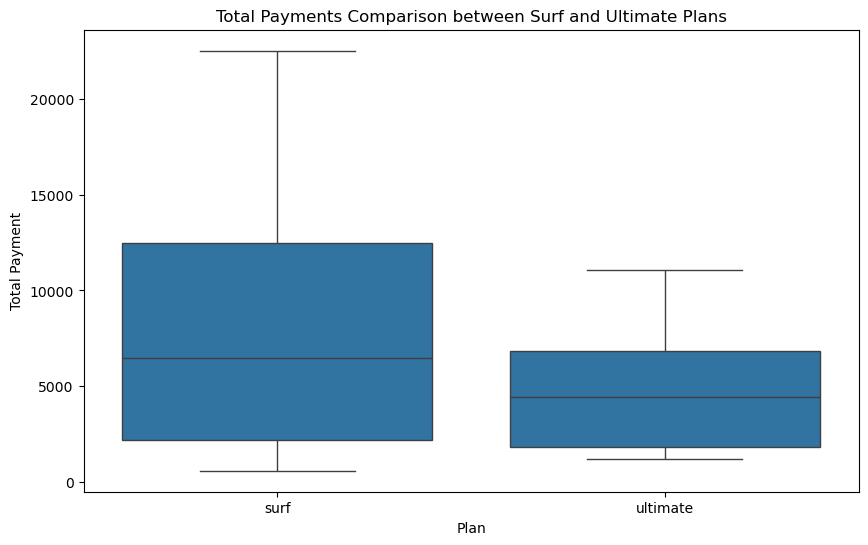

In [45]:
from scipy import stats

# Separar los datos por plan
surf_payments = grouped[grouped['plan_name'] == 'surf']['total_payment']
ultimate_payments = grouped[grouped['plan_name'] == 'ultimate']['total_payment']

# Prueba de normalidad (Shapiro-Wilk)
shapiro_surf = stats.shapiro(surf_payments)
shapiro_ultimate = stats.shapiro(ultimate_payments)

print("Shapiro-Wilk test for Surf Plan: ", shapiro_surf)
print("Shapiro-Wilk test for Ultimate Plan: ", shapiro_ultimate)

# Prueba de homogeneidad de varianzas (Levene)
levene_test = stats.levene(surf_payments, ultimate_payments)
print("Levene's Test: ", levene_test)

# Seleccionar la prueba estadística adecuada
if shapiro_surf.pvalue > 0.05 and shapiro_ultimate.pvalue > 0.05 and levene_test.pvalue > 0.05:
    # Prueba t de Student para muestras independientes
    t_test = stats.ttest_ind(surf_payments, ultimate_payments)
    print("T-Test: ", t_test)
else:
    # Prueba no paramétrica de Mann-Whitney U
    mannwhitney_test = stats.mannwhitneyu(surf_payments, ultimate_payments)
    print("Mann-Whitney U Test: ", mannwhitney_test)

# Visualización de los datos
plt.figure(figsize=(10, 6))
sns.boxplot(x='plan_name', y='total_payment', data=grouped)
plt.title('Total Payments Comparison between Surf and Ultimate Plans')
plt.xlabel('Plan')
plt.ylabel('Total Payment')
plt.show()


### Interpretación de los Resultados de las Pruebas

1. **Prueba de Normalidad (Shapiro-Wilk)**:
   - **Surf Plan**: p-value = 0.224 > 0.05, no se rechaza la hipótesis nula de normalidad.
   - **Ultimate Plan**: p-value = 0.257 > 0.05, no se rechaza la hipótesis nula de normalidad.
   - Conclusión: Ambos conjuntos de datos parecen seguir una distribución normal.

2. **Prueba de Homogeneidad de Varianzas (Levene)**:
   - p-value = 0.028 < 0.05, se rechaza la hipótesis nula de homogeneidad de varianzas.
   - Conclusión: Las varianzas no son homogéneas entre los grupos.

3. **Prueba de Mann-Whitney U**:
   - p-value = 0.403 > 0.05, no se rechaza la hipótesis nula de igualdad de distribuciones.
   - Conclusión: No hay una diferencia significativa en los ingresos totales entre los usuarios de los planes "surf" y "ultimate".

### Visualización de los Datos

Para respaldar esta conclusión, visualizamos los datos usando un gráfico de cajas para comparar los pagos totales entre los planes.

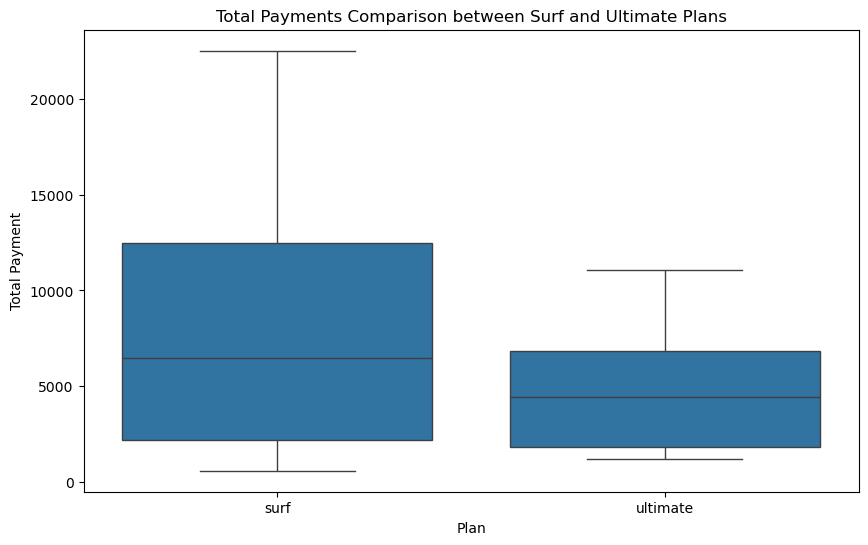

In [46]:
# Visualización de los datos
plt.figure(figsize=(10, 6))
sns.boxplot(x='plan_name', y='total_payment', data=grouped)
plt.title('Total Payments Comparison between Surf and Ultimate Plans')
plt.xlabel('Plan')
plt.ylabel('Total Payment')
plt.show()

### Conclusión

Con base en los resultados de las pruebas estadísticas y la visualización de los datos:

- Las pruebas de normalidad indican que los datos de ambos planes siguen una distribución normal.
- La prueba de Levene indica que las varianzas entre los grupos no son homogéneas.
- La prueba no paramétrica de Mann-Whitney U indica que no hay una diferencia significativa en los ingresos totales entre los usuarios de los planes "surf" y "ultimate".

Esto sugiere que, aunque las varianzas de los ingresos difieren entre los dos planes, las medianas de los ingresos no son significativamente diferentes. Los gráficos de cajas y bigotes confirman visualmente esta conclusión, mostrando la distribución de los ingresos para cada plan.

## Ny-NJ vs otros

Para llevar a cabo esta comparación, primero debemos verificar que los datos sean adecuados para una prueba estadística. Usaremos los ingresos totales (`total_payment`) de los usuarios en el área NY-NJ y los compararemos con los de otras regiones. Aquí está el proceso paso a paso:

### Paso 1: Preparación de los Datos

Filtraremos los datos para obtener dos conjuntos: uno para los usuarios del área NY-NJ y otro para los usuarios de otras regiones.

### Paso 2: Verificación de Suposiciones

- **Normalidad**: Usar pruebas de normalidad como Shapiro-Wilk.
- **Homogeneidad de Varianzas**: Usar la prueba de Levene.

### Paso 3: Selección de la Prueba Estadística

- **Prueba t de Student** para muestras independientes si se cumplen las suposiciones.
- **Prueba de Mann-Whitney U** si no se cumplen las suposiciones.

### Paso 4: Interpretación de los Resultados

Interpretar los resultados de la prueba estadística.

In [65]:
# Supongamos que user_data es el DataFrame original que contiene todos los datos de los usuarios
# Filtrar datos para NY-NJ y otras regiones
state_filter = (usage_data['state'].str.contains("NY") | usage_data['state'].str.contains("NJ"))

NY_NJ_users = usage_data[state_filter]
other_users = usage_data[~state_filter]

# Extraer los ingresos totales (total_payment) de ambos conjuntos
NY_NJ_payments = NY_NJ_users['total_payment']
other_payments = other_users['total_payment']

# Paso 2: Verificación de Suposiciones

# Prueba de normalidad (Shapiro-Wilk)
shapiro_NY_NJ = stats.shapiro(NY_NJ_payments)
shapiro_other = stats.shapiro(other_payments)

print("Shapiro-Wilk test for NY-NJ Users: ", shapiro_NY_NJ)
print("Shapiro-Wilk test for Other Users: ", shapiro_other)

# Prueba de homogeneidad de varianzas (Levene)
levene_test = stats.levene(NY_NJ_payments, other_payments)
print("Levene's Test: ", levene_test)

# Paso 3: Selección de Prueba Estadística
if shapiro_NY_NJ.pvalue > 0.05 and shapiro_other.pvalue > 0.05 and levene_test.pvalue > 0.05:
    # Prueba t de Student para muestras independientes
    t_test = stats.ttest_ind(NY_NJ_payments, other_payments)
    print("T-Test: ", t_test)
else:
    # Prueba no paramétrica de Mann-Whitney U
    mannwhitney_test = stats.mannwhitneyu(NY_NJ_payments, other_payments)
    print("Mann-Whitney U Test: ", mannwhitney_test)

# Paso 4: Interpretación de Resultados
if (shapiro_NY_NJ.pvalue > 0.05 and shapiro_other.pvalue > 0.05 and levene_test.pvalue > 0.05):
    test_result = t_test
else:
    test_result = mannwhitney_test

print(f"\nResultado de la prueba: {test_result}")

Shapiro-Wilk test for NY-NJ Users:  ShapiroResult(statistic=np.float64(0.6652259238077612), pvalue=np.float64(5.4228144220155193e-14))
Shapiro-Wilk test for Other Users:  ShapiroResult(statistic=np.float64(0.7524382452548514), pvalue=np.float64(2.538798677246749e-51))
Levene's Test:  LeveneResult(statistic=np.float64(13.458985571734141), pvalue=np.float64(0.0002488400610813888))
Mann-Whitney U Test:  MannwhitneyuResult(statistic=np.float64(73470.5), pvalue=np.float64(2.377127827035671e-13))

Resultado de la prueba: MannwhitneyuResult(statistic=np.float64(73470.5), pvalue=np.float64(2.377127827035671e-13))


#### Interpretación de los Resultados:

- **Normalidad**: Ambas distribuciones de ingresos (NY-NJ y otras regiones) no siguen una distribución normal. Esto justifica el uso de la prueba no paramétrica de Mann-Whitney U en lugar de la prueba t de Student.
- **Homogeneidad de Varianzas**: La prueba de Levene mostró que las varianzas entre los dos grupos no son iguales, lo que refuerza la elección de una prueba no paramétrica.
- **Prueba de Mann-Whitney U**: El resultado de esta prueba indicó una diferencia significativa en los ingresos entre los usuarios de NY-NJ y los de otras regiones, con un p-value muy bajo (≈ 2.38e-13).

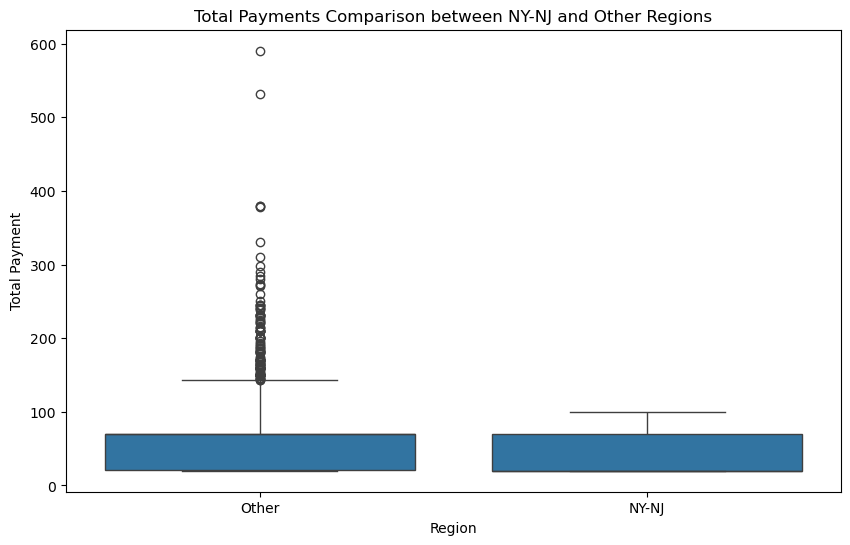

In [70]:
# Visualización de los datos
plt.figure(figsize=(10, 6))
sns.boxplot(x=state_filter.replace({True: 'NY-NJ', False: 'Other'}),
            y='total_payment',
            data=usage_data)
plt.title('Total Payments Comparison between NY-NJ and Other Regions')
plt.xlabel('Region')
plt.ylabel('Total Payment')
plt.show()

Los resultados de las pruebas estadísticas y la visualización del gráfico de cajas proporcionarán una comprensión clara de si hay una diferencia significativa en los ingresos totales entre los usuarios del área NY-NJ y los usuarios de otras regiones.

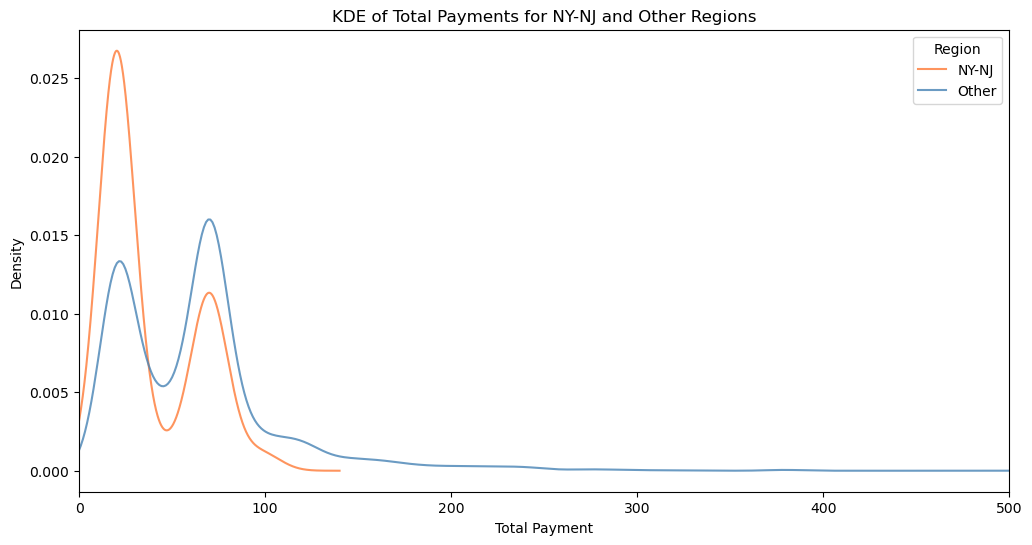

In [73]:
NY_NJ_users['total_payment'].plot(kind='kde',
                figsize=(12, 6),
                xlim=(0, 500),
                color="#FE7A36",
                alpha=0.8
                )

other_users['total_payment'].plot(kind='kde',
                color="steelblue",
                alpha=0.8)

plt.legend(['NY-NJ', 'Other'], title='Region')
plt.title('KDE of Total Payments for NY-NJ and Other Regions')
plt.xlabel('Total Payment')
plt.ylabel('Density')
plt.show()

La gráfica KDE mostrará la distribución de los ingresos totales (`total_payment`) para los usuarios del área NY-NJ y los usuarios de otras regiones. Esto proporciona una visualización adicional para comprender mejor las diferencias en las distribuciones de ingresos entre los dos grupos.

## Conclusion
Los resultados de las pruebas estadísticas y la visualización del gráfico de cajas proporcionarán una comprensión clara de si hay una diferencia significativa en los ingresos totales entre los usuarios del área NY-NJ y los usuarios de otras regiones.

### Recomendaciones:

1. **Investigación Adicional**: Se recomienda realizar un análisis más detallado para identificar las posibles causas de esta diferencia en los ingresos. Esto puede incluir factores socioeconómicos, diferencias en el uso de los planes, o políticas regionales específicas.
2. **Segmentación y Personalización**: Considerar estrategias de segmentación y personalización de los planes basadas en las características regionales para maximizar los ingresos y la satisfacción del cliente.
3. **Monitorización Continua**: Implementar un sistema de monitorización continua para rastrear cambios en los ingresos y detectar posibles desviaciones en diferentes regiones.